<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

In [2]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [3]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

In [4]:
from google.colab import drive

drive._mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


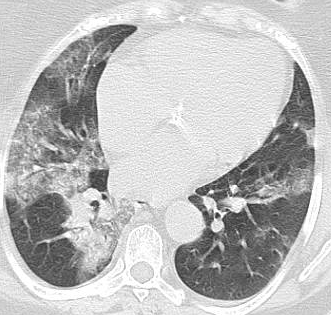

In [5]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [6]:
path = Path(f"{dataset_path}")

In [7]:
imgs = get_image_files(f"{dataset_path}")
imgs

(#2481) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1233).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1205).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1220).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1216).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1223).png')...]

In [8]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

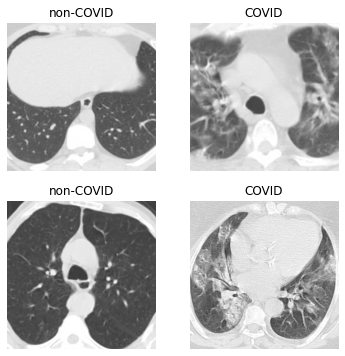

In [9]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [10]:
dls.train.vocab

['non-COVID', 'COVID']

In [11]:
res34 = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [12]:
lr = 1e-3
res34.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.930324,0.470983,0.790890,0.786008,00:54
1,0.630205,0.344952,0.870544,0.954733,00:45


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.319053,0.187729,0.923695,0.946502,01:01
1,0.196530,0.145296,0.956341,0.946502,00:59
2,0.131047,0.122096,0.967347,0.975309,00:59
3,0.088490,0.125201,0.963265,0.971193,00:59


In [13]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [14]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.319053,0.187729,0.923695,0.946502
1,0.196530,0.145296,0.956341,0.946502
2,0.131047,0.122096,0.967347,0.975309
3,0.088490,0.125201,0.963265,0.971193


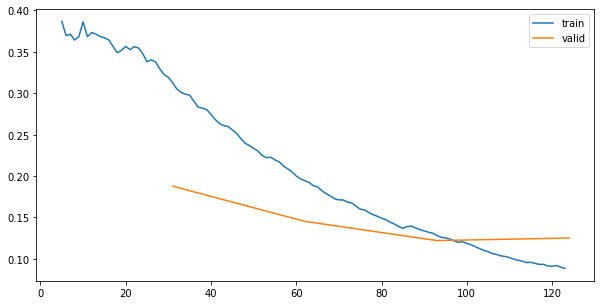

In [15]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

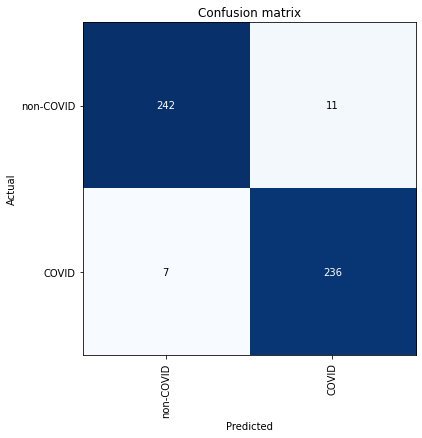

In [16]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

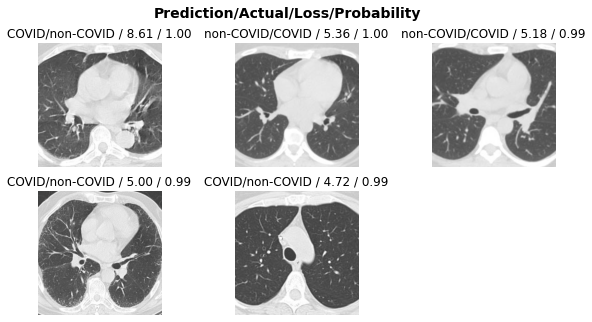

In [17]:
interp.plot_top_losses(5, figsize=(10,5))

In [18]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([4.9999e-06, 9.9999e-01]))

In [19]:
res34.export('res34.pkl')

In [20]:
"""
del res34
gc.collect()
torch.cuda.empty_cache()
"""

'\ndel res34\ngc.collect()\ntorch.cuda.empty_cache()\n'

In [55]:
covid = covid.new(
    item_tfms=Resize(350),
    batch_tfms=[DeterministicFlip, Contrast(p=1, draw=1.50)])
dls = covid.dataloaders(path)

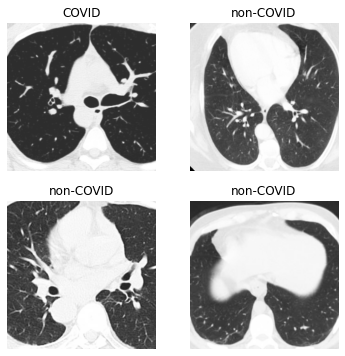

In [56]:
dls.train.show_batch(max_n=4)

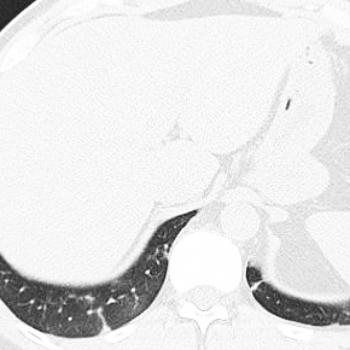

In [57]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [58]:
res34_con = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [59]:
lr = 1e-3
res34_con.fine_tune(5, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.785205,0.569228,0.775583,0.888889,00:47


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.426841,0.495893,0.823944,0.962963,01:01
1,0.306648,0.224201,0.917172,0.934156,01:01
2,0.212975,0.291074,0.906615,0.958848,01:02
3,0.147765,0.169442,0.932000,0.958848,01:01
4,0.109778,0.170056,0.932540,0.967078,01:01


In [60]:
df_rec34_con = pd.DataFrame(res34_con.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [61]:
df_rec34_con

,train_loss,valid_loss,f1_score,recall_score
0,0.426841,0.495893,0.823944,0.962963
1,0.306648,0.224201,0.917172,0.934156
2,0.212975,0.291074,0.906615,0.958848
3,0.147765,0.169442,0.932000,0.958848
4,0.109778,0.170056,0.932540,0.967078


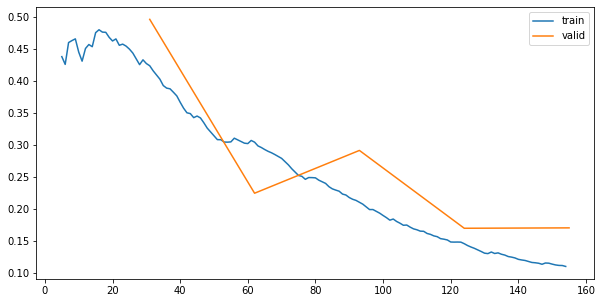

In [62]:
plt.figure(figsize=(10,5))
res34_con.recorder.plot_loss()

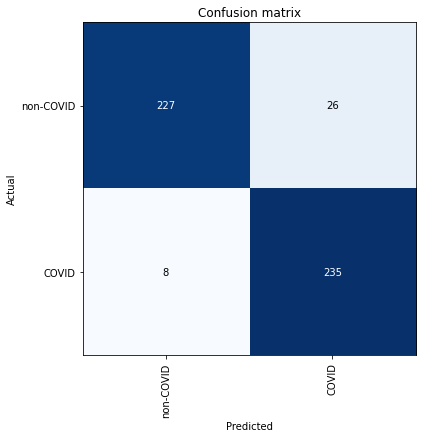

In [63]:
interp = ClassificationInterpretation.from_learner(res34_con)
interp.plot_confusion_matrix(figsize=(6,6))

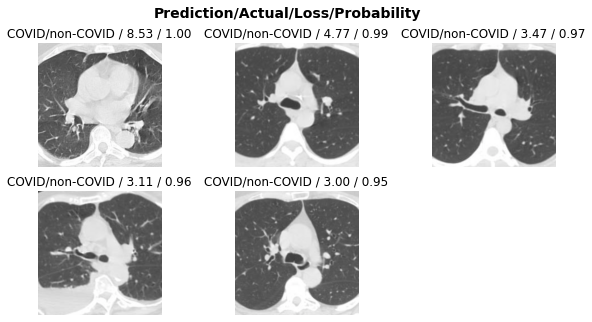

In [64]:
interp.plot_top_losses(5, figsize=(10,5))

In [65]:
res34_con.export('res34_con.pkl')

In [32]:
"""
del res34_con
gc.collect()
torch.cuda.empty_cache()
"""

'\ndel res34_con\ngc.collect()\ntorch.cuda.empty_cache()\n'

In [33]:
covid = covid.new(
    item_tfms=Resize(350),
    batch_tfms=[DeterministicFlip, RandomErasing(1, min_aspect=0.3, sh=0.1)])
dls = covid.dataloaders(path)

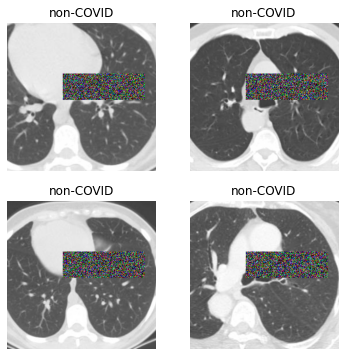

In [34]:
dls.train.show_batch(max_n=4)

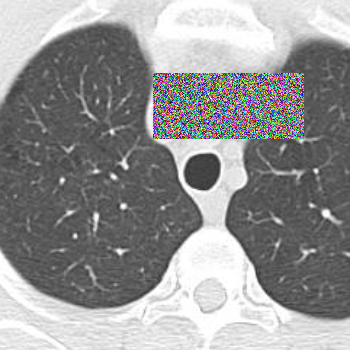

In [35]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [36]:
res34_noise = cnn_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

In [37]:
lr = 1e-3
res34_noise.fine_tune(6, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.941363,0.460005,0.814978,0.761317,00:47
1,0.712753,0.360159,0.859375,0.905350,00:47


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.423927,0.287245,0.888446,0.917695,01:01
1,0.328197,0.259927,0.914286,0.855967,01:01
2,0.251871,0.118917,0.954545,0.950617,01:01
3,0.193423,0.140141,0.958506,0.950617,01:01
4,0.151882,0.120057,0.964211,0.942387,01:00
5,0.120428,0.102406,0.968815,0.958848,01:00


In [38]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [39]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.423927,0.287245,0.888446,0.917695
1,0.328197,0.259927,0.914286,0.855967
2,0.251871,0.118917,0.954545,0.950617
3,0.193423,0.140141,0.958506,0.950617
4,0.151882,0.120057,0.964211,0.942387
5,0.120428,0.102406,0.968815,0.958848


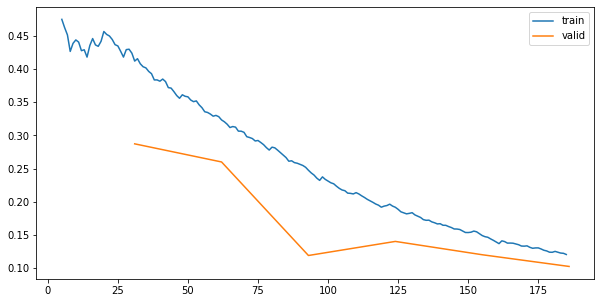

In [40]:
plt.figure(figsize=(10,5))
res34_noise.recorder.plot_loss()

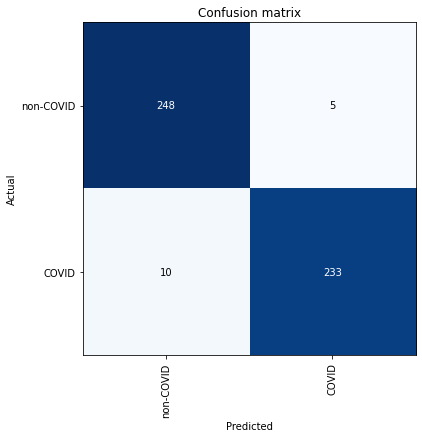

In [41]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

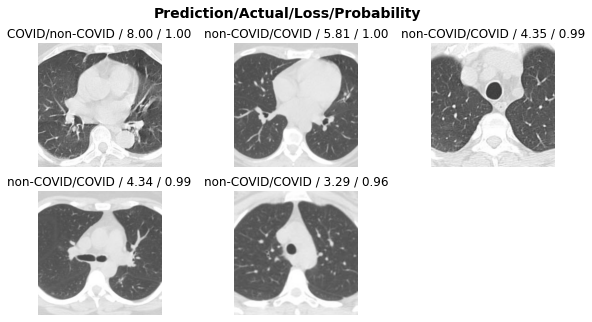

In [42]:
interp.plot_top_losses(5, figsize=(10,5))

In [43]:
res34_noise.export('res34_noise.pkl')

In [44]:
"""
del res34_noise
gc.collect()
torch.cuda.empty_cache()
"""

'\ndel res34_noise\ngc.collect()\ntorch.cuda.empty_cache()\n'

## Inference

Load the model from URL

In [45]:
"""
res34 = load_learner(f'{folder_path}res34.pkl')
res34_con = load_learner(f'{folder_path}res34_con.pkl')
res34_noise = load_learner(f'{folder_path}res34_noise.pkl')
"""

"\nres34 = load_learner(f'{folder_path}res34.pkl')\nres34_con = load_learner(f'{folder_path}res34_con.pkl')\nres34_noise = load_learner(f'{folder_path}res34_noise.pkl')\n"

In [66]:
class Ensemble:
  def __init__(self, dl, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    self.model_list = []
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      self.model_list.append(model)
      print(f'loaded: {name}')
  
  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p.numpy())
    
    probas = np.stack(probas, axis=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for model in self.model_list:
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = []
    _,_, targs, decoded,_ = self.get_preds(self.dl)
    for name, metric in metrics.items():
      res.append(metric(decoded, targs))
    return res


In [67]:
en = Ensemble(dls.valid, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=['non-covid', 'covid'])
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-covid', 'covid']
loaded: res34
loaded: res34_con
loaded: res34_noise


In [68]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('covid',
 array([0.48382664, 0.51617336], dtype=float32),
 array([0.3905154 , 0.39051542], dtype=float32))

In [69]:
en.models['res34_con'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('COVID', TensorBase(1), TensorBase([0.0312, 0.9688]))

In [70]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

In [71]:
en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

[0.9734151329243353, 0.9794238683127572]

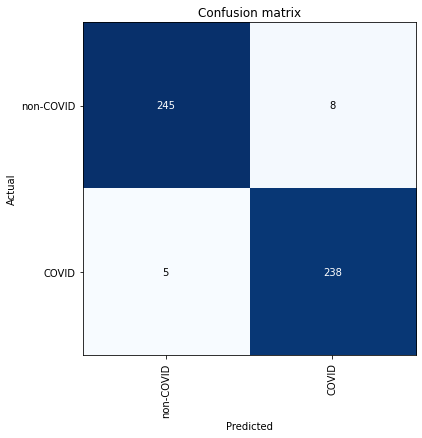

In [72]:
# interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) -> calls get_preds
interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

In [73]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU" -O res34.pkl && rm -rf /tmp/cookies.txt &> 2

--2021-12-17 21:22:43--  https://docs.google.com/uc?export=download&confirm=cbO&id=151TwzuC8exmzntoh-iQDXPJT71A1CcGU
Resolving docs.google.com (docs.google.com)... 108.177.97.139, 108.177.97.102, 108.177.97.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘res34.pkl’

res34.pkl               [ <=>                ]   3.22K  --.-KB/s    in 0s      

2021-12-17 21:22:43 (29.4 MB/s) - ‘res34.pkl’ saved [3297]

